In [ ]:
!pip install timm
! pip install --upgrade sympy


  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import copy
from statistics import mean
from dataclasses import dataclass, field
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
import requests
import zipfile
from io import BytesIO
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import timm
import random

In [ ]:
 # Acquisisco e estraggo lo zip in una directory
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip'

# Effettuo una richiesta GET per scaricare il file
response = requests.get(url)

if response.status_code == 200:
    print("Download completo!")

   # Estraggo il file zip in memoria
    with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
        # Controllo i file contenuti nel zip
        file_list = zip_ref.namelist()
        print("File presenti nel zip:", file_list)

        extract_path = "Dataset"

        # Creo la directory se non esiste
        os.makedirs(extract_path, exist_ok=True)

        zip_ref.extractall(extract_path)
        print("File estratti nella directory:", extract_path)

# Controllo l'estrazione al fine di ottenre la lista dei file estratti e se tutti sono stati estratti
extracted_files = os.listdir(extract_path)

if set(file_list) == set(extracted_files):
    print("Tutti i file sono stati estratti correttamente.")
else:
    missing_files = set(file_list) - set(extracted_files)

    # controllo se vi sono  eventuali file mancanti
    with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
        for missing_file in missing_files:
            zip_ref.extract(missing_file, extract_path)
            print(f"File estratto: {missing_file}")

    print("Tutti i file sono stati estratti correttamente.")


print("Operazione completata.")

Output streaming troncato alle ultime 5000 righe.
File estratto: dataset/train/Crispy Chicken/Crispy Chicken-Train (715)_30fb75caf6944a079c3a38441a56be19.jpeg
File estratto: dataset/train/sushi/2276986_a0938615ad8d4437a7b3ee071e627676.jpg
File estratto: dataset/train/Hot Dog/Hot Dog - Train (570)_901079e029714e3f80234bffdd98cc29.jpeg
File estratto: dataset/val/omelette/2711042_9333e4621cda41b285b06b03813861b4.jpg
File estratto: dataset/train/omelette/1497372_2355c4e5ac6845d7a518f9ab47e1b3c1.jpg
File estratto: dataset/train/Crispy Chicken/Crispy Chicken-Train (966)_df058b6963ec4a35ac263231cfffdffc.jpeg
File estratto: dataset/train/apple_pie/2666921_365944a82d284d1f82f0820853189661.jpg
File estratto: dataset/train/omelette/3734753_119ee13e3ab14b3aa4e356d136c36ff1.jpg
File estratto: dataset/train/Crispy Chicken/Crispy Chicken-Train (91)_1eb0abdfba454f7c9a6ba01d0d8d309c.jpeg
File estratto: dataset/train/ice_cream/995441_f575f0ada6cd4ef5a3bf10024e2a05d9.jpg
File estratto: dataset/val/sushi/

In [ ]:
# Controllo se nel dataset ci sono immagini corrotte con una apposita funzione
def check_corrupted_images(directory):
    corrupted_images = []


    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:

                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Immagine corrotta rilevata: {file_path}")
                corrupted_images.append(file_path)

    if not corrupted_images:
        print("Nessuna immagine corrotta trovata.")
    else:
        print(f"Immagini corrotte: {corrupted_images}")

# Eseguo  il comando di controllo delle immagini corrotte
extract_path = "/content/Dataset/dataset"
check_corrupted_images(extract_path)

Nessuna immagine corrotta trovata.


In [ ]:

def check_image_counts(data_dir):
    categories = ['train', 'val', 'test']
    total_counts = {category: 0 for category in categories}

    for category in categories:
        category_dir = os.path.join(data_dir, category)

        if not os.path.exists(category_dir):
            print(f"Directory non trovata: {category_dir}")
            continue

        print(f"\n{'#'*20} Conteggio immagini per la categoria: {category.upper()} {'#'*20}\n")
        classes = os.listdir(category_dir)

        category_count = 0  # Contatore per la categoria corrente

        for cls in classes:
            class_dir = os.path.join(category_dir, cls)
            if not os.path.isdir(class_dir):
                continue

            images = os.listdir(class_dir)
            class_count = len(images)  # Conta le immagini per la classe

            # Stampa il conteggio per la classe corrente
            print(f"Classe: {cls} - Numero di immagini: {class_count}")

            # Aggiungi il conteggio della classe al totale della categoria
            category_count += class_count

        # Memorizza il conteggio totale per la categoria
        total_counts[category] = category_count
        print(f"\nTotale immagini per la categoria '{category}': {category_count}\n")

    # Stampa i conteggi totali per tutte le categorie
    print(f"\n{'#'*20} Conteggi Totali {'#'*20}")
    for category, count in total_counts.items():
        print(f"Totale immagini in '{category}': {count}")

data_dir = '/content/Dataset/dataset'  # Modifica in base al tuo percorso

# Esegui il conteggio delle immagini per ciascun set
check_image_counts(data_dir)


#################### Conteggio immagini per la categoria: TRAIN ####################

Classe: sushi - Numero di immagini: 640
Classe: omelette - Numero di immagini: 640
Classe: Taquito - Numero di immagini: 640
Classe: cheesecake - Numero di immagini: 640
Classe: Taco - Numero di immagini: 640
Classe: Hot Dog - Numero di immagini: 640
Classe: Crispy Chicken - Numero di immagini: 640
Classe: ice_cream - Numero di immagini: 640
Classe: chicken_curry - Numero di immagini: 640
Classe: apple_pie - Numero di immagini: 640
Classe: Donut - Numero di immagini: 640
Classe: Fries - Numero di immagini: 640
Classe: Baked Potato - Numero di immagini: 640
Classe: Sandwich - Numero di immagini: 640

Totale immagini per la categoria 'train': 8960


#################### Conteggio immagini per la categoria: VAL ####################

Classe: sushi - Numero di immagini: 160
Classe: omelette - Numero di immagini: 160
Classe: Taquito - Numero di immagini: 160
Classe: cheesecake - Numero di immagini: 160
Cla

In [ ]:
def calculate_dataset_statistics(data_dir):
    categories = ['train', 'val', 'test']
    statistics = {category: {
        'count': 0,
        'total_width': 0,
        'total_height': 0,
        'total_pixel_count': 0,
        'formats': set(),
        'channels': set(),
        'low_brightness_count': 0,
        'low_resolution_count': 0
    } for category in categories}

    # Parametri di soglia
    brightness_threshold = 50    # Soglia di luminosità media per considerare un'immagine "bassa luminosità"
    low_resolution_threshold = (256, 256)  # Risoluzione minima per evitare "bassa risoluzione"

    for category in categories:
        category_dir = os.path.join(data_dir, category)

        if not os.path.exists(category_dir):
            print(f"Directory non trovata: {category_dir}")
            continue

        classes = os.listdir(category_dir)
        for cls in classes:
            class_dir = os.path.join(category_dir, cls)
            if not os.path.isdir(class_dir):
                continue

            images = os.listdir(class_dir)

            for img_name in images:
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        # Dimensioni e formato
                        width, height = img.size
                        img_format = img.format.lower()  # Formato immagine (es: jpg)
                        mode = img.mode

                        # Aggiornamento statistiche di base
                        statistics[category]['count'] += 1
                        statistics[category]['total_width'] += width
                        statistics[category]['total_height'] += height
                        statistics[category]['total_pixel_count'] += width * height
                        statistics[category]['formats'].add(img_format)
                        statistics[category]['channels'].add(len(img.getbands()))

                        # Calcolo luminosità media
                        grayscale_img = img.convert("L")  # Converti in scala di grigi
                        avg_brightness = np.mean(np.array(grayscale_img))

                        # Verifica bassa luminosità
                        if avg_brightness < brightness_threshold:
                            statistics[category]['low_brightness_count'] += 1

                        # Verifica bassa risoluzione
                        if width < low_resolution_threshold[0] or height < low_resolution_threshold[1]:
                            statistics[category]['low_resolution_count'] += 1

                except Exception as e:
                    print(f"Errore nell'aprire l'immagine {img_name}: {e}")

        # Calcola e stampa le statistiche medie per la categoria
        count = statistics[category]['count']
        if count > 0:
            avg_width = statistics[category]['total_width'] / count
            avg_height = statistics[category]['total_height'] / count
            avg_pixel_count = statistics[category]['total_pixel_count'] / count

            print(f"\nCaratteristiche per il set {category}:\n")
            print(f"  Numero totale di immagini: {count}")
            print(f"  Dimensione media delle immagini: {avg_width:.2f} x {avg_height:.2f}")
            print(f"  Conteggio medio dei pixel per immagine: {avg_pixel_count:.2f}")
            print(f"  Formati di file presenti: {', '.join(statistics[category]['formats'])}")
            print(f"  Numero di canali presenti: {max(statistics[category]['channels'])}")
            print(f"  Immagini con bassa luminosità: {statistics[category]['low_brightness_count']}")
            print(f"  Immagini con bassa risoluzione: {statistics[category]['low_resolution_count']}\n")

data_dir = '/content/Dataset/dataset'  # Modifica in base al tuo percorso

# Calcola e visualizza le statistiche per ciascun set
calculate_dataset_statistics(data_dir)


Caratteristiche per il set train:

  Numero totale di immagini: 8960
  Dimensione media delle immagini: 512.00 x 512.00
  Conteggio medio dei pixel per immagine: 262144.00
  Formati di file presenti: jpeg, png
  Numero di canali presenti: 3
  Immagini con bassa luminosità: 51
  Immagini con bassa risoluzione: 0


Caratteristiche per il set val:

  Numero totale di immagini: 2240
  Dimensione media delle immagini: 512.00 x 512.00
  Conteggio medio dei pixel per immagine: 262144.00
  Formati di file presenti: jpeg, png
  Numero di canali presenti: 3
  Immagini con bassa luminosità: 5
  Immagini con bassa risoluzione: 0


Caratteristiche per il set test:

  Numero totale di immagini: 2800
  Dimensione media delle immagini: 512.00 x 512.00
  Conteggio medio dei pixel per immagine: 262144.00
  Formati di file presenti: jpeg, png
  Numero di canali presenti: 3
  Immagini con bassa luminosità: 16
  Immagini con bassa risoluzione: 0




Visualizzazione immagini train set:


<Figure size 1500x1000 with 0 Axes>

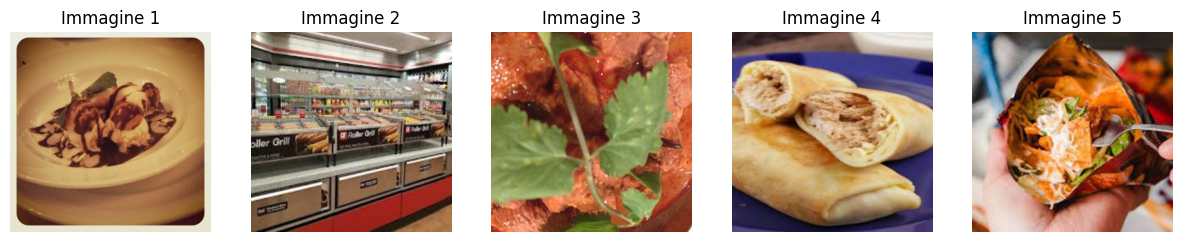


Visualizzazione immagini validation set:


<Figure size 1500x1000 with 0 Axes>

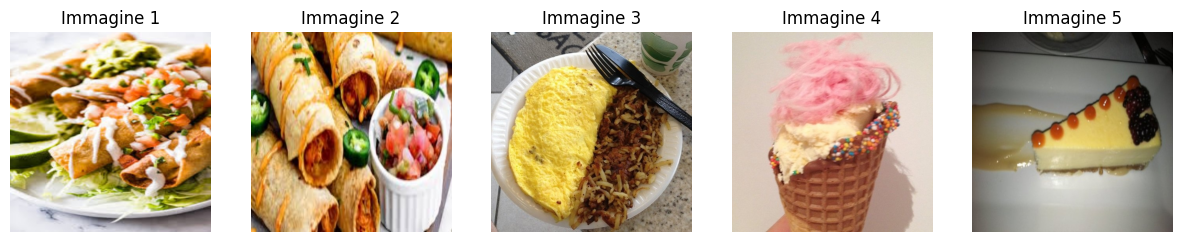


Visualizzazione immagini test set:


<Figure size 1500x1000 with 0 Axes>

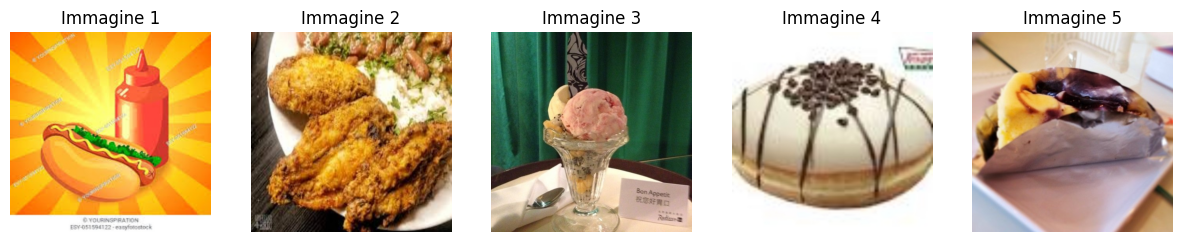

In [ ]:

# creo una  Funzione per visualizzare 5 immagini casuali da ciascun set
def visualize_random_images(data_dir, category, num_images=5):
    category_dir = os.path.join(data_dir, category)

    # imposto questa parte parte della funzione per Controllare se la directory esiste
    if not os.path.exists(category_dir):
        print(f"Directory non trovata: {category_dir}")
        return

    images = []
    # unoisti un ciclo per individuare le immagini in tutte le sottocartelle (classi) in maniera casuale
    for root, _, files in os.walk(category_dir):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg', 'bmp')):
                images.append(os.path.join(root, file))


    if len(images) > 0:
        random_images = random.sample(images, min(len(images), num_images))

        # strutturo per la Visualizzazione delle immagini
        fig, axes = plt.subplots(1, len(random_images), figsize=(15, 5))
        for i, img_path in enumerate(random_images):
            try:
                with Image.open(img_path) as img:
                    ax = axes[i]
                    ax.imshow(img)
                    ax.axis('off')  # Nascondi assi
                    ax.set_title(f"Immagine {i+1}")
            except Exception as e:
                print(f"Errore nell'aprire l'immagine: {e}")
    else:
        print(f"Nessuna immagine trovata nella directory {category_dir}")


data_dir = '/content/Dataset/dataset'  # Modifica in base alla tua directory

# procedo per il print di 5 immagini casuali per ogni set separatamente
plt.figure(figsize=(15, 10))
print("\nVisualizzazione immagini train set:")
visualize_random_images(data_dir, 'train', num_images=5)
plt.show()

plt.figure(figsize=(15, 10))
print("\nVisualizzazione immagini validation set:")
visualize_random_images(data_dir, 'val', num_images=5)
plt.show()

plt.figure(figsize=(15, 10))
print("\nVisualizzazione immagini test set:")
visualize_random_images(data_dir, 'test', num_images=5)
plt.show()

In [ ]:
"""le immagini sembrano avere una ottima definizione e anche da questo campionamento casuale non vi sembrano immagini corrotte
o particolarmente anomale"""

'le immagini sembrano avere una ottima definizione e anche da questo campionamento casuale non vi sembrano immagini corrotte\no particolarmente anomale'

Train dataset size: 8960
Validation dataset size: 2240
Test dataset size: 2800
Batch dimensioni immagini: torch.Size([32, 3, 224, 224])
Batch labels: tensor([ 5,  3, 10,  5,  2,  1, 12,  6,  3,  5, 11,  8,  3,  1,  4, 12,  8, 10,
         0,  4,  5, 12,  8, 12, 10,  7,  3,  9, 10,  0,  4, 13])


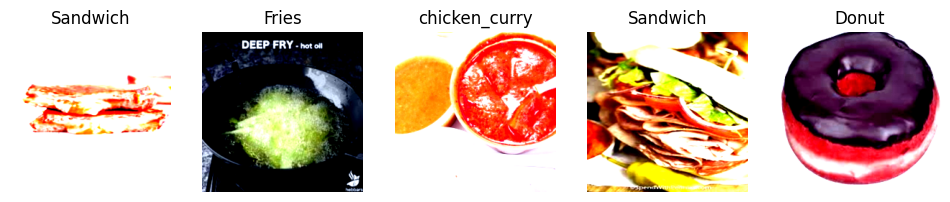

In [ ]:
# Definisco il percorso principale per il dataset
data_dir = '/content/Dataset/dataset'

# Inizializzo le trasformazioni da applicare alle immagini
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Crop casuale di una porzione dell'immagine e resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variazioni casuali di colore
    transforms.ToTensor(),  # Conversione in tensore
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalizzazione
])

# Carico il train set, validation set e test set
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform)

# Creo i DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verifico che i dataset siano caricati correttamente
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Funzione per visualizzare immagini in batch
def show_images(images, labels, class_names):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 12))
    for i, (img, lbl) in enumerate(zip(images, labels)):
        img = img / 2 + 0.5  # Denormalizza per renderlo visibile
        np_img = img.numpy()
        axes[i].imshow(np.transpose(np_img, (1, 2, 0)))
        axes[i].set_title(class_names[lbl])
        axes[i].axis('off')
    plt.show()

# Visualizza un batch di immagini dal train loader
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f'Batch dimensioni immagini: {images.size()}')
print(f'Batch labels: {labels}')

# Visualizzazione batch
class_names = train_dataset.classes
show_images(images[:5], labels[:5], class_names)


In [ ]:
# Esploro il dataset vedendo la lunghezza la tipologia di classe e il numero
print("Numero di classi train:", len(train_dataset.classes))
print("Classi train:", train_dataset.classes)
print("Classi val:", val_dataset.classes)
print("Numero di classi val:", len(val_dataset.classes))
print("Classi test:", test_dataset.classes)
print("Numero di classi test:", len(test_dataset.classes))


Numero di classi train: 14
Classi train: ['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taco', 'Taquito', 'apple_pie', 'cheesecake', 'chicken_curry', 'ice_cream', 'omelette', 'sushi']
Classi val: ['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taco', 'Taquito', 'apple_pie', 'cheesecake', 'chicken_curry', 'ice_cream', 'omelette', 'sushi']
Numero di classi val: 14
Classi test: ['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taco', 'Taquito', 'apple_pie', 'cheesecake', 'chicken_curry', 'ice_cream', 'omelette', 'sushi']
Numero di classi test: 14


In [ ]:



train_path = '/content/Dataset/dataset/train'
val_path = '/content/Dataset/dataset/val'
test_path = '/content/Dataset/dataset/test'




# creo una Funzione per contare le immagini all'interno di ciascuna directory
def count_images_in_directory(directory_path):
    counts = {}
    for class_name in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([name for name in os.listdir(class_path) if name.endswith('.jpeg') or name.endswith('.jpg')])
            counts[class_name] = num_images
    return counts

# procedo con il Conteggio e la visualizzazione delle immagini
train_counts = count_images_in_directory(train_path)
val_counts = count_images_in_directory(val_path)
test_counts = count_images_in_directory(test_path)


print("Train counts:", train_counts)
print("Validation counts:", val_counts)
print("Test counts:", test_counts)

Train counts: {'sushi': 640, 'omelette': 640, 'Taquito': 640, 'cheesecake': 640, 'Taco': 640, 'Hot Dog': 629, 'Crispy Chicken': 640, 'ice_cream': 640, 'chicken_curry': 640, 'apple_pie': 640, 'Donut': 635, 'Fries': 640, 'Baked Potato': 640, 'Sandwich': 640}
Validation counts: {'sushi': 160, 'omelette': 160, 'Taquito': 160, 'cheesecake': 160, 'Taco': 160, 'Hot Dog': 160, 'Crispy Chicken': 160, 'ice_cream': 160, 'chicken_curry': 160, 'apple_pie': 160, 'Donut': 158, 'Fries': 160, 'Baked Potato': 160, 'Sandwich': 160}
Test counts: {'sushi': 200, 'omelette': 200, 'Taquito': 200, 'cheesecake': 200, 'Taco': 200, 'Hot Dog': 196, 'Crispy Chicken': 200, 'ice_cream': 200, 'chicken_curry': 200, 'apple_pie': 200, 'Donut': 196, 'Fries': 200, 'Baked Potato': 200, 'Sandwich': 200}


In [ ]:
"""In generale, il dataset sembra ben distribuito e pronto per essere utilizzato nella rete neurale."""

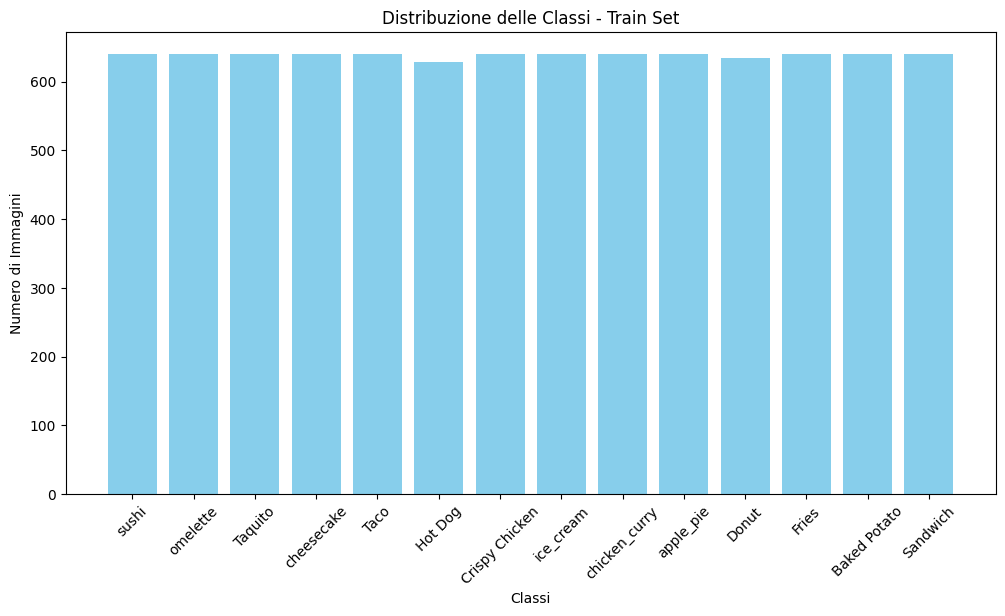

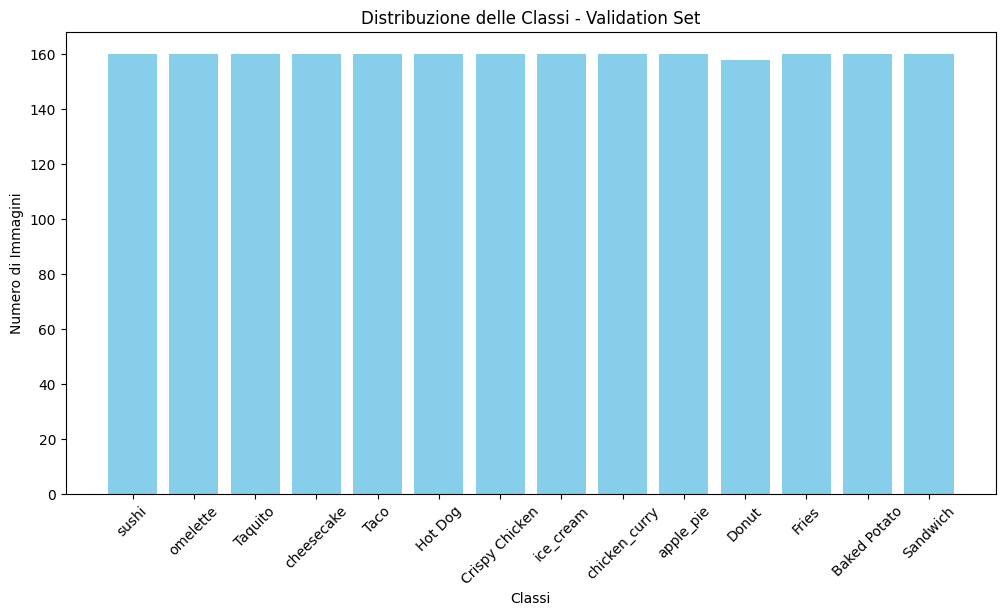

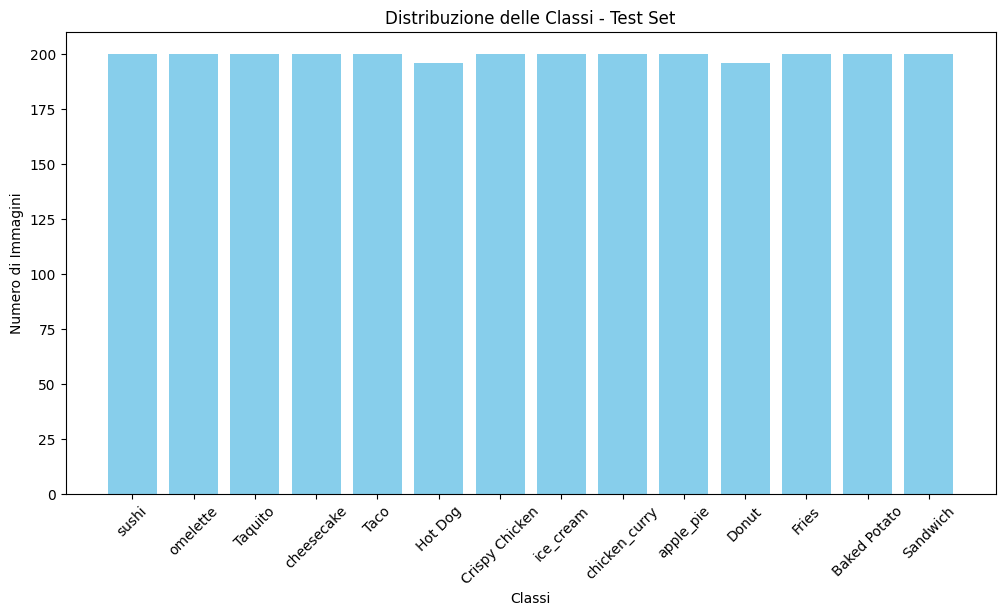

In [ ]:
def plot_class_distribution(counts, title):
    classes = list(counts.keys())
    num_images = list(counts.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, num_images, color='skyblue')
    plt.xlabel('Classi')
    plt.ylabel('Numero di Immagini')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

""" Stampo e visualizza la distribuzione delle classi tramite istrogrammi per vedere
se i set sono ben bilanciati"""

plot_class_distribution(train_counts, 'Distribuzione delle Classi - Train Set')
plot_class_distribution(val_counts, 'Distribuzione delle Classi - Validation Set')
plot_class_distribution(test_counts, 'Distribuzione delle Classi - Test Set')



In [ ]:
"""i vari set del dataset train , validation e test sono stati suddivisi
in maniera bilanciata presentando tutti un numero simili di immagini"""

'i vari set del dataset train , validation e test sono stati suddivisi\nin maniera bilanciata presentando tutti un numero simili di immagini'

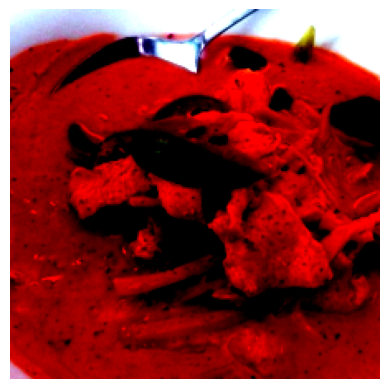

Etichetta: chicken_curry


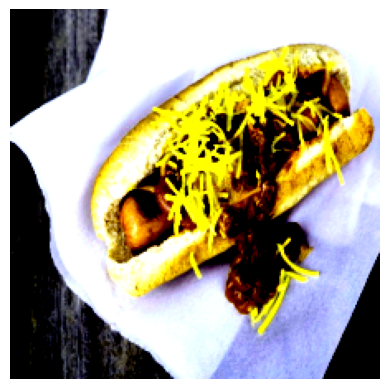

Etichetta: Hot Dog


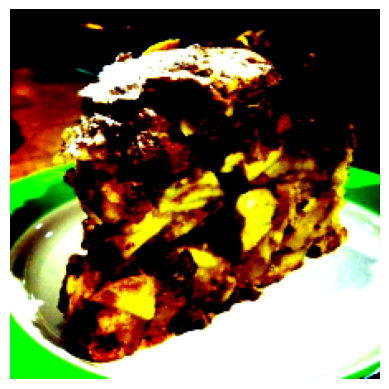

Etichetta: apple_pie

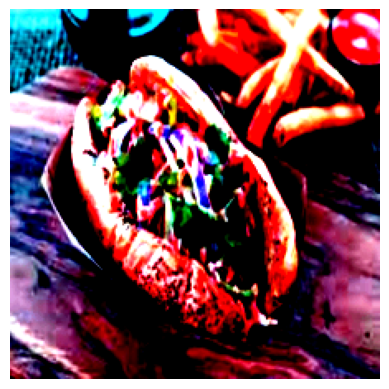

Etichetta: Hot Dog


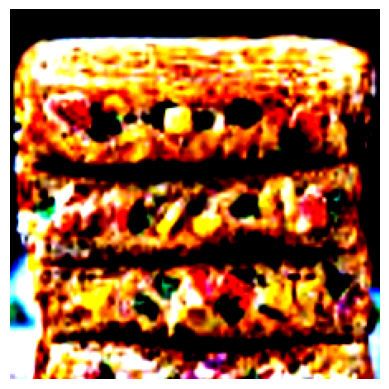

Etichetta: Sandwich


In [ ]:
"""Definisco una funzione per visualizzare le immagini a seguito delle
trasformazioni del dataloader"""

def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Estraggo alcune immagini dal train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Visualizzo le prime 5 immagini
for i in range(5):
    imshow(images[i])  #
    label_name = class_names[labels[i].item()]
    print(f'Etichetta: {label_name}')

In [ ]:
"""procedo con la costruzione di un modello neurale tramite pythorch
e utilozzo dell'apposita gpu per cercare di avere un buon modello di riconoscimento"""

# Definisco il dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carico un modello EfficientNet pre-addestrato per utilizzare il transfer learning
model = timm.create_model('efficientnet_b0', pretrained=True)

# Definisco il numero di classi dal dataset di addestramento
num_classes = len(train_dataset.classes)

# Modifico l'ultimo layer per adattare il modello al numero di classi specifico del dataset
if hasattr(model, 'classifier'):  # Alcuni modelli hanno 'classifier'
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
elif hasattr(model, 'fc'):  # Altri modelli usano 'fc'
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

# Sposto il modello sul dispositivo GPU o CPU
model = model.to(device)

# Definisco la funzione di perdita e l'ottimizzatore Adam
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Verifico che il modello sia stato configurato correttamente
print(f'Model structure: {model}')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Model structure: EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [ ]:
# creo una Funzione per salvare il modello
def save_checkpoint(model, optimizer, epoch, val_loss, val_acc, y_true, y_pred, filename="best_model.pth"):
    report = classification_report(y_true, y_pred, output_dict=True)
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'classification_report': report
    }
    torch.save(checkpoint, filename)
    print(f'Model saved at epoch {epoch} with validation loss: {val_loss:.4f} and accuracy: {val_acc:.4f}')

# creo una Funzione per caricare il checkpoint
def load_checkpoint(model, optimizer, filename="best_model.pth"):
    if os.path.exists(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f'Model loaded from checkpoint at epoch {start_epoch}')
        return model, optimizer, start_epoch
    else:
        print(f"No checkpoint found at {filename}. Starting from scratch.")
        return model, optimizer, 0

In [ ]:
"""Creo una classe di earlystopping per stoppare il modello in caso non ci siano miglioramenti per 5 epoche con un margine di 0.001
se non ci sono miglioramenti per oltre 5 epoche l'addestramento si interrompera"""


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early stopping after {self.patience} epochs with no improvement.")
                self.early_stop = True

In [ ]:
"""definisco la funzione del modello che funzionera tramite check point e
early stopping"""

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, patience=5, checkpoint_path="best_model.pth"):
    early_stopping = EarlyStopping(patience=patience)
    best_model_wts = model.state_dict()
    best_loss = np.inf
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels.data)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            save_checkpoint(model, optimizer, epoch + 1, val_loss, val_acc, y_true, y_pred, checkpoint_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Stopping early at epoch {epoch + 1}")
            model.load_state_dict(best_model_wts)
            return model, train_losses, val_losses, val_accuracies

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_accuracies
    return model, train_losses, val_losses, val_accuracies

In [ ]:
"""comando per far parire il training del modello"""


best_model, train_losses, val_losses, val_accuracies = train_model_with_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=25,
    patience=5,
    checkpoint_path="best_model.pth"
)

Epoch 1/25
----------
Train Loss: 0.5212, Acc: 0.8325
Val Loss: 0.6489, Acc: 0.8027
Model saved at epoch 1 with validation loss: 0.6489 and accuracy: 0.8027
Epoch 2/25
----------
Train Loss: 0.3902, Acc: 0.8758
Val Loss: 0.6500, Acc: 0.7991
Epoch 3/25
----------
Train Loss: 0.3222, Acc: 0.8945
Val Loss: 0.6114, Acc: 0.8085
Model saved at epoch 3 with validation loss: 0.6114 and accuracy: 0.8085
Epoch 4/25
----------
Train Loss: 0.2586, Acc: 0.9146
Val Loss: 0.5965, Acc: 0.8259
Model saved at epoch 4 with validation loss: 0.5965 and accuracy: 0.8259
Epoch 5/25
----------
Train Loss: 0.2389, Acc: 0.9225
Val Loss: 0.5982, Acc: 0.8339
Epoch 6/25
----------
Train Loss: 0.2085, Acc: 0.9301
Val Loss: 0.7016, Acc: 0.8165
Epoch 7/25
----------
Train Loss: 0.2054, Acc: 0.9316
Val Loss: 0.6032, Acc: 0.8375
Epoch 8/25
----------
Train Loss: 0.1557, Acc: 0.9479
Val Loss: 0.7760, Acc: 0.8112
Epoch 9/25
----------
Train Loss: 0.1666, Acc: 0.9462
Val Loss: 0.6399, Acc: 0.8317
Early stopping after 5 ep

                precision    recall  f1-score   support

  Baked Potato       0.90      0.82      0.86       200
Crispy Chicken       0.80      0.84      0.82       200
         Donut       0.87      0.94      0.90       200
         Fries       0.83      0.89      0.86       200
       Hot Dog       0.81      0.78      0.79       200
      Sandwich       0.82      0.84      0.83       200
          Taco       0.76      0.61      0.68       200
       Taquito       0.71      0.81      0.76       200
     apple_pie       0.86      0.63      0.73       200
    cheesecake       0.79      0.83      0.81       200
 chicken_curry       0.80      0.88      0.84       200
     ice_cream       0.84      0.84      0.84       200
      omelette       0.83      0.82      0.82       200
         sushi       0.85      0.93      0.89       200

      accuracy                           0.82      2800
     macro avg       0.82      0.82      0.82      2800
  weighted avg       0.82      0.82      0.82 

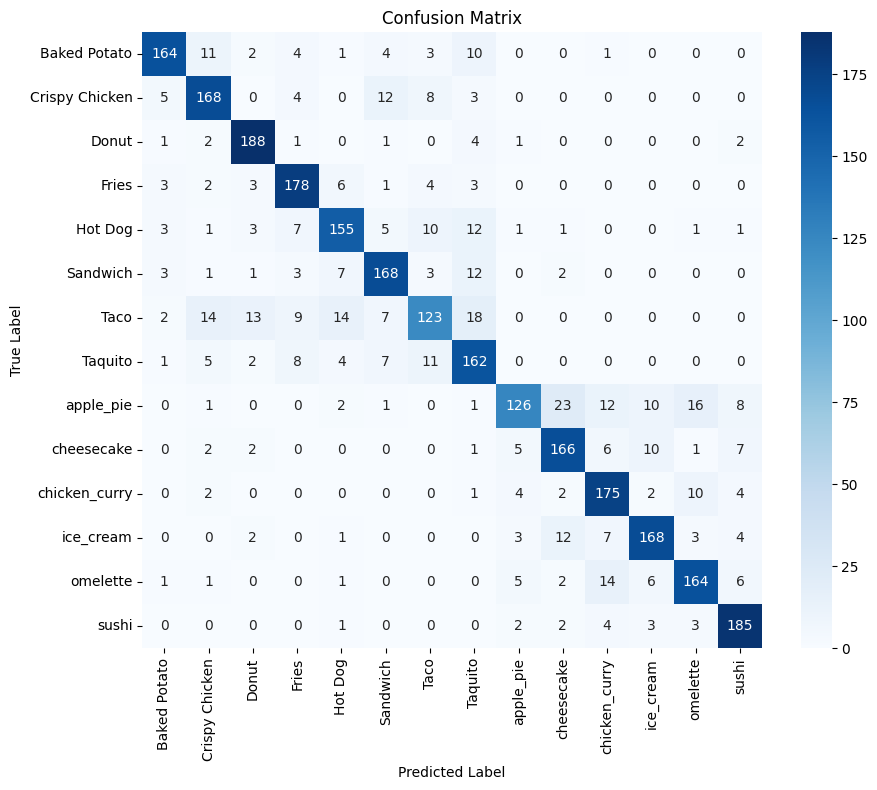

In [ ]:
"""sezione per procedere alla valutazione de modello rispetto ai
risultati ottenuto tra le varie epoche e generare e visualizzare la reportistica
in merito alle metriche venute fuori dal report"""


# costruisco Funzione per valutare il modello
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# costruisco Funzione per visualizzare la matrice di confusione
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# procedo con la Valutazione del modello
all_preds, all_labels = evaluate_model(best_model, test_loader, device)

# procedo con la Generazione di report di classificazione
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# procedo con la Visualizzazione della matrice di confusione
plot_confusion_matrix(all_labels, all_preds, train_dataset.classes)

In [ ]:
""" il modello in generale ha una accuracy
abbastanza alta del 82 ma sembra avere difficoltà per la classe Taquito del 641 circa che proveremo
a esaminare preliminarmente tramite visualizzazione di immagini"""

' il modello in generale ha una accuracy\nabbastanza alta del 82 ma sembra avere difficoltà per la classe Taquito del 641 circa che proveremo\na esaminare preliminarmente tramite visualizzazione di immagini'

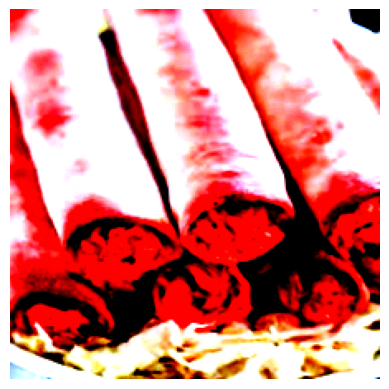

Etichetta: Taquito


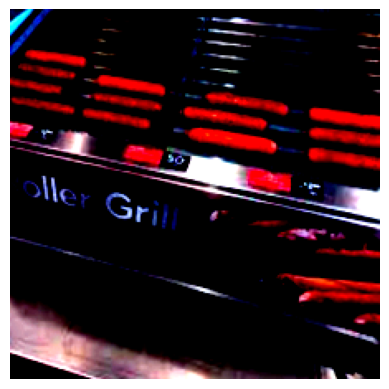

Etichetta: Taquito


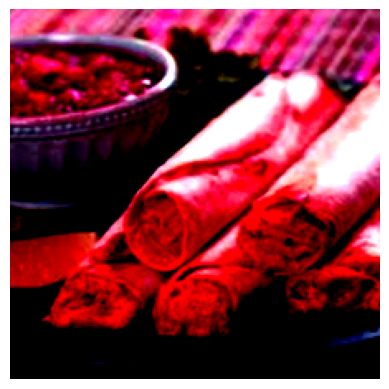

Etichetta: Taquito


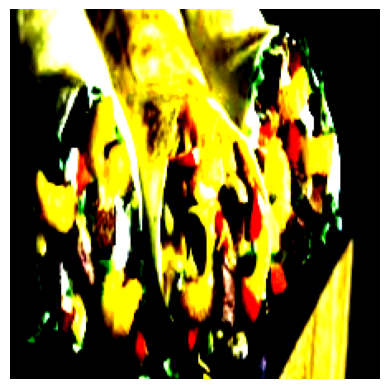

Etichetta: Taquito


In [ ]:


# Definisco una funzione per visualizzare le immagini
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Riordina le dimensioni
    plt.axis('off')  # Nasconde gli assi
    plt.show()  # Mostra l'immagine

# Estraggo alcune immagini dal train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Nome delle classi
class_names = train_dataset.classes

# Visualizza solo 5 immagini della classe 'Taco'
max_images = 5
count = 0

for i in range(len(images)):
    label_name = class_names[labels[i].item()]
    if label_name == 'Taquito':  # Controllo se l'etichetta è 'Taco'
        imshow(images[i])
        print(f'Etichetta: {label_name}')  # Stampa l'etichetta dell'immagine
        count += 1
        if count >= max_images:
            break

In [ ]:
"""dalle immagini non vi sembrano eccessive difficolta del modello a riconoscere taco, si potrebbe migliorare ulteriormente il modello
caricando dal check point applicando
tecniche di Random Search per la selezione dei parametri durante l'addestramento in maniera casuale e tecniche di dropout per spegnere alcuni neuroni
in maniera selattiva per fare in modo che non avvengano fenomeni di autocorrelazione dei neuroni durante l'apprendimento
e nel contempo provando modifiche dei batch size e del learning rate attraverso i caricamenti dei vari checkpoints anche per velocizzare il processo di addestramento"""

"dalle immagini non vi sembrano eccessive difficolta del modello a riconoscere taco, si potrebbe migliorare ulteriormente il modello\ncaricando dal check point applicando\ntecniche di Random Search per la selezione dei parametri durante l'addestramento in maniera casuale e tecniche di dropout per spegnere alcuni neuroni\nin maniera selattiva per fare in modo che non avvengano fenomeni di autocorrelazione dei neuroni durante l'apprendimento\ne nel contempo provando modifiche dei batch size e del learning rate attraverso i caricamenti dei vari checkpoints anche per velocizzare il processo di addestramento"